*  This is a basic tutorial which gives an introduction into how gunpowder is used for data loading, augmentation, training, and prediction

*  Based on tutorial here: http://funkey.science/gunpowder/tutorial_simple_pipeline.html#a-minimal-pipeline

*  For the gunpowder API, see here: http://funkey.science/gunpowder/api.html

*  If you are familiar with gunpowder already, check out the affinities/lsd tutorials for training

*  Before starting, click "Runtime" in the top panel, select "Change runtime type" and then choose "GPU"

*  Try running each cell consecutively to see what is happening before changing things around

*  Some cells are collapsed by default, these are generally utility functions. Double click to expand/collapse

*  Sometimes colab can be slow when training, if this happens you may need to restart the runtime. also, you generally can only run one session at a time.

In [1]:
import gunpowder as gp
import logging
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import zarr

from funlib.learn.torch.models import UNet
from skimage import data
from skimage import filters
from skimage.io import imread
from tqdm import tqdm
from time import sleep

%matplotlib inline
logging.basicConfig(level=logging.INFO)

In [2]:
# make sure we all see the same
np.random.seed(19623)
random.seed(19623)

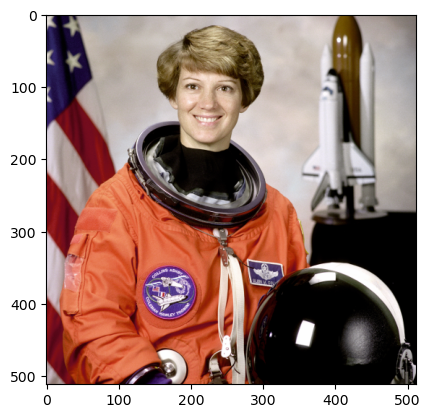

In [3]:
raw_data = data.astronaut()
plt.imshow(raw_data)

In [4]:
print(raw_data.shape)

(512, 512, 3)


In [5]:
# make the channels first
raw_data_t = raw_data.transpose(2,0,1)
print(raw_data_t.shape)

(3, 512, 512)


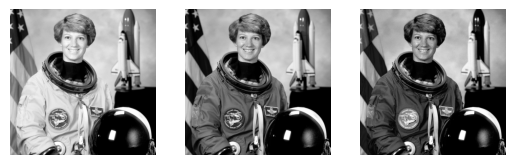

In [6]:
fig, (r, g, b) = plt.subplots(1,3)

r.imshow(raw_data_t[0], cmap='gray')
g.imshow(raw_data_t[1], cmap='gray')
b.imshow(raw_data_t[2], cmap='gray')
r.axis('off')
g.axis('off')
b.axis('off')
plt.show()

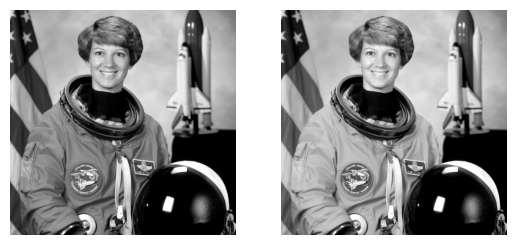

In [7]:
avg = np.mean(raw_data_t, axis=0)
transf = np.array([0.7, 0.2,0.1])
bri = np.sum(np.multiply(raw_data_t, transf[:, np.newaxis, np.newaxis]), axis = 0)

fig, (average, transformation) = plt.subplots(1,2)
average.imshow(avg, cmap='gray')
average.axis('off')
transformation.imshow(bri, cmap='gray')
transformation.axis('off')
plt.show()

raw shape: (3, 512, 512)
gt shape: (1, 512, 512)


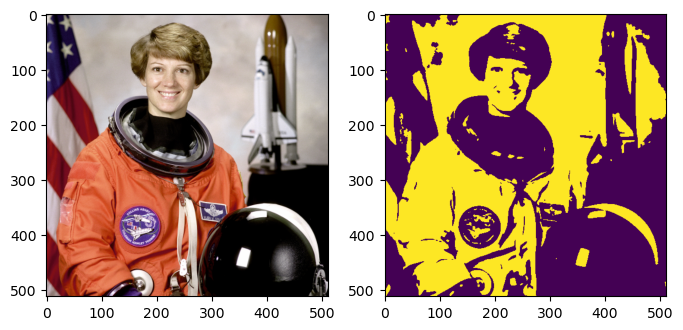

In [8]:
# create some dummy "ground-truth" to train on
gt_data = filters.gaussian(raw_data_t[0], sigma=1.0) > 0.7
gt_data = gt_data[np.newaxis,:].astype(np.float32)

print(f"raw shape: {raw_data_t.shape}")
print(f"gt shape: {gt_data.shape}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(raw_data)
ax[1].imshow(gt_data[0])

In [9]:
# create output zarr container
f = zarr.open('sample_data.zarr', 'w')

# write data into zarr container (two datasets - raw and ground truth)
f['raw'] = raw_data_t
f['ground_truth'] = gt_data

# set an arbitrary resolution
f['raw'].attrs['resolution'] = (1, 1)
f['ground_truth'].attrs['resolution'] = (1, 1)

In [10]:
#@title utility function to view a batch

# helper function to show image(s), channels first
def imshow(raw=None, ground_truth=None, prediction=None, h=None, draw_box=None):
    rows = 0
    if raw is not None:
        rows += 1
        cols = raw.shape[0] if len(raw.shape) > 3 else 1
    if ground_truth is not None:
        rows += 1
        cols = ground_truth.shape[0] if len(ground_truth.shape) > 3 else 1
    if prediction is not None:
        rows += 1
        cols = prediction.shape[0] if len(prediction.shape) > 3 else 1
    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(10, 4),
        sharex=True,
        sharey=True,
        squeeze=False
    )
    if h is not None:
        fig.subplots_adjust(hspace=h)
    
    if draw_box:
        box = patches.Rectangle(
                (draw_box[0]),
                draw_box[1],
                draw_box[2],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
        )

        # Add the patch to the Axes
        axes[0][0].add_patch(box)
    
    def wrapper(
        data,
        row,
        name="RAW"):
        
        if len(data.shape) == 3:
            if name == 'RAW':
                axes[0][0].imshow(data.transpose(1,2,0))
                axes[0][0].set_title(name)
            else:
                axes[row][0].imshow(data[0])
                axes[row][0].set_title(name)  
            
        else:
            for i, im in enumerate(data):
                if name == 'RAW':
                    axes[0][i].imshow(im.transpose(1, 2, 0))
                    axes[0][i].set_title(name)
                else:
                    axes[row][i].imshow(im[0])
                    axes[row][i].set_title(name)
    
    row=0
        
    if raw is not None:
        wrapper(raw,row=row)
        row += 1
    if ground_truth is not None:
        wrapper(ground_truth,row=row,name='GROUND TRUTH')
        row += 1
    if prediction is not None:
        wrapper(prediction,row=row,name='PREDICTION')
        row += 1
    
    plt.show()

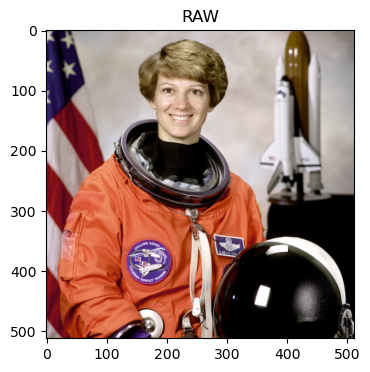

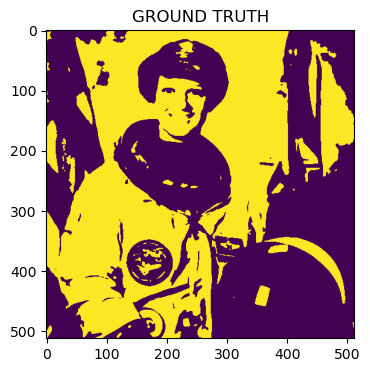

In [11]:
# same data, just in zarr
imshow(raw=zarr.open('sample_data.zarr')['raw'][:])
imshow(ground_truth=zarr.open('sample_data.zarr')['ground_truth'][:])

In [12]:
# declare arrays to use in the pipeline
raw = gp.ArrayKey('RAW')

In [13]:
# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    'sample_data.zarr',  # the zarr container
    {raw: 'raw'},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True)}  # meta-information
)
pipeline = source

print(pipeline)

ZarrSource[sample_data.zarr], providing: None


In [14]:
# formulate a request for "raw" (start at zero with a size of 64)
request = gp.BatchRequest()
request_roi = gp.Roi((0, 0), (64, 64))
request[raw] = request_roi

batch returned: 
	RAW: ROI: [0:64, 0:64] (64, 64), voxel size: (1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



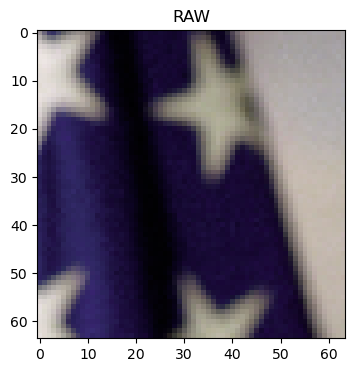

In [15]:
# build the pipeline...
with gp.build(pipeline):

  # ...and request a batch
  batch = pipeline.request_batch(request)

# show the content of the batch
print(f"batch returned: {batch}")

imshow(raw=batch[raw].data)

In [16]:
print(request[raw].roi)

[0:64, 0:64] (64, 64)


In [17]:
print(f"offset: {request[raw].roi.get_begin()}")
print(f"shape: {request[raw].roi.get_shape()}")

offset: (0, 0)
shape: (64, 64)


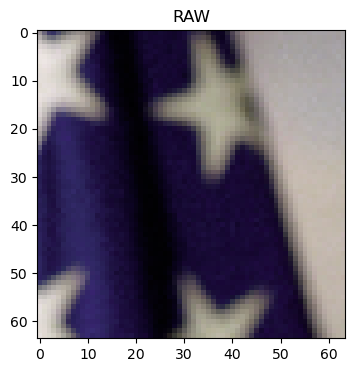

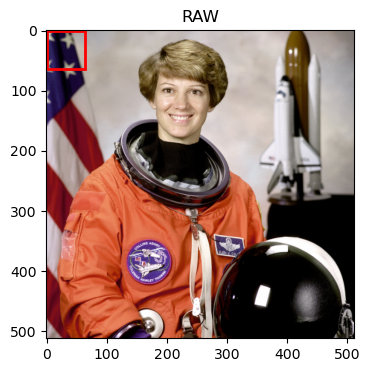

In [18]:
# location context
imshow(raw=batch[raw].data)

imshow(
    raw=zarr.open('sample_data.zarr')['raw'][:],
    draw_box=(
        request[raw].roi.get_begin()[::-1],
        request[raw].roi.get_shape()[0],
        request[raw].roi.get_shape()[1]
    )
)

batch returned: 
	RAW: ROI: [50:114, 150:214] (64, 64), voxel size: (1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



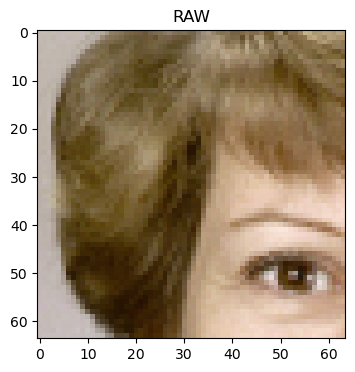

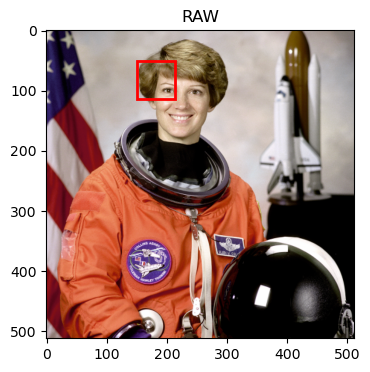

In [19]:
# change the offset of the request from (0, 0) --> (50, 150)
request[raw] = gp.Roi((50, 150), (64, 64))

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

print(f"batch returned: {batch}")
imshow(batch[raw].data)

imshow(
    raw=zarr.open('sample_data.zarr')['raw'][:],
    draw_box=(
        request[raw].roi.get_begin()[::-1],
        request[raw].roi.get_shape()[0],
        request[raw].roi.get_shape()[1]
    )
)

In [20]:
# add a RandomLocation node to randomly select a sample

random_location = gp.RandomLocation()
pipeline = source + random_location

print(pipeline)

ZarrSource[sample_data.zarr] -> RandomLocation


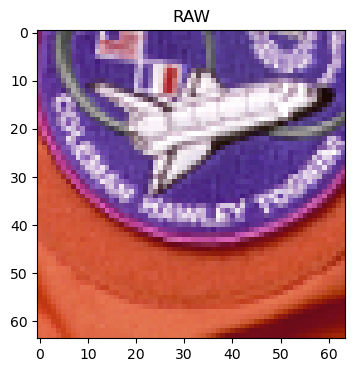

In [21]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data)

ZarrSource[sample_data.zarr] -> RandomLocation -> SimpleAugment


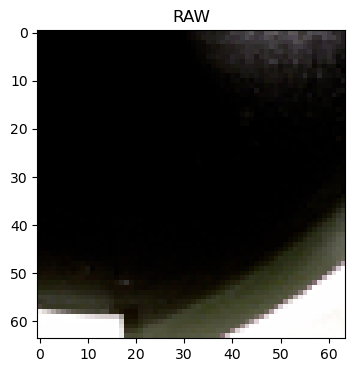

In [22]:
# add a node to randomly mirror / transpose a batch
simple_augment = gp.SimpleAugment()
pipeline = source + random_location + simple_augment

print(pipeline)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data)

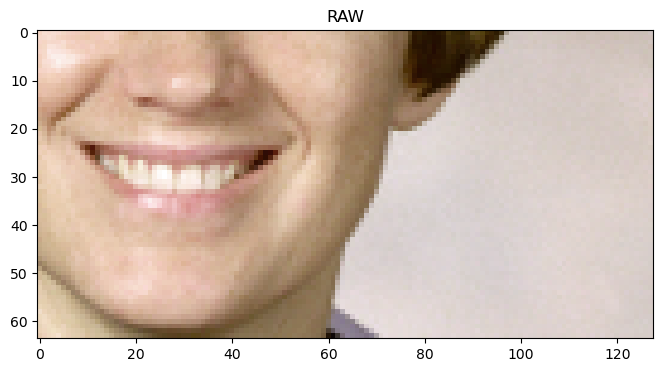

In [23]:
# create a larger request roi
request[raw] = gp.Roi((0, 0), (64, 128))

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data)

ZarrSource[sample_data.zarr] -> RandomLocation -> SimpleAugment -> ElasticAugment


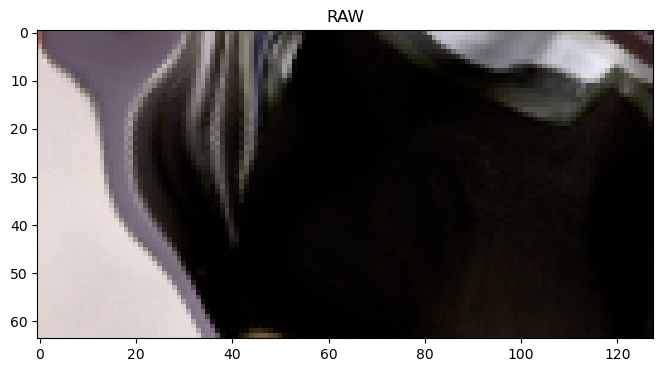

In [24]:
# elastically deform a batch
elastic_augment = gp.ElasticAugment(
  control_point_spacing=(16, 16),
  jitter_sigma=(4.0, 4.0),
  rotation_interval=(0, math.pi/2))
pipeline = source + random_location + simple_augment + elastic_augment

print(pipeline)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data)

ZarrSource[sample_data.zarr] -> Normalize -> RandomLocation -> SimpleAugment -> ElasticAugment -> IntensityAugment


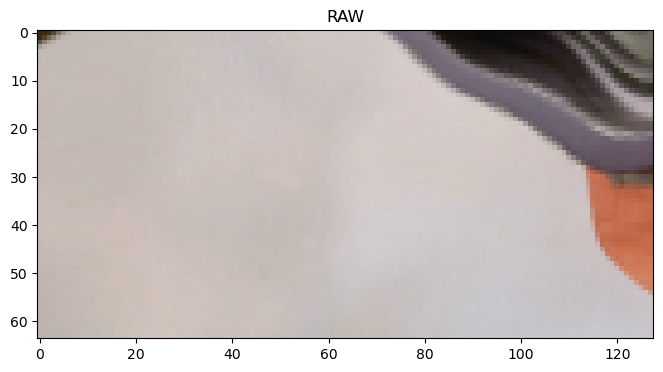

In [34]:
# normalize values to floats between 0 and 1
normalize = gp.Normalize(raw)

# augment the intensity of a batch
intensity_augment = gp.IntensityAugment(
  raw,
  scale_min=0.8,
  scale_max=1.2,
  shift_min=-0.2,
  shift_max=0.2)

# add random noise
noise_augment = gp.NoiseAugment(raw)

# build pipeline
pipeline = (
  source +
  normalize +
  random_location +
  simple_augment +
  elastic_augment +
  intensity_augment
  #noise_augment
  )

print(pipeline)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data)

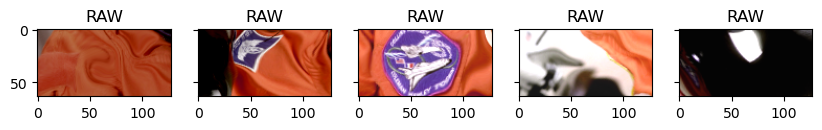

In [36]:
# create a batch with 5 samples
stack = gp.Stack(5)

pipeline = (
  source +
  normalize +
  random_location +
  simple_augment +
  elastic_augment +
  intensity_augment +
  stack)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data)

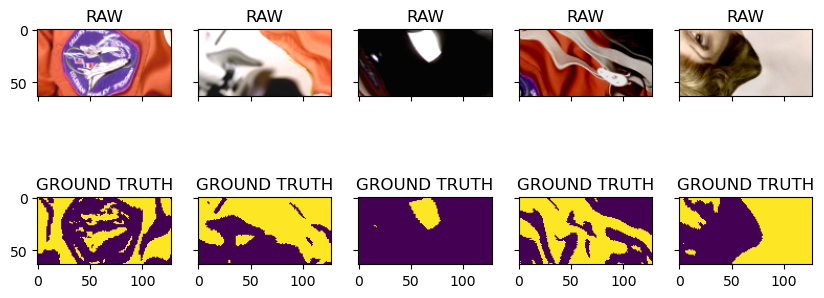

In [38]:
# request multiple arrays (i.e raw and ground truth)

# first create an array key for the ground truth
gt = gp.ArrayKey('GROUND_TRUTH')

# load both data sources
source = gp.ZarrSource(
    'sample_data.zarr', # zarr container
    {
      raw: 'raw', # raw dataset
      gt: 'ground_truth' # ground truth dataset
    },
    {
      raw: gp.ArraySpec(interpolatable=True),
      gt: gp.ArraySpec(interpolatable=False)
    })

# create ground truth request roi (same as raw)
request[gt] = gp.Roi((0, 0), (64, 128))

pipeline = (
  source +
  normalize +
  random_location +
  simple_augment +
  elastic_augment +
  intensity_augment +
  stack)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(raw=batch[raw].data, ground_truth=batch[gt].data)

In [40]:
# make sure we all see the same
torch.manual_seed(18)

# create a basic 2D U-Net mapping from 3 input channels (rgb)
# to one output channel (segmentation - binary in this case)
unet = UNet(
  in_channels=3,
  num_fmaps=4,
  fmap_inc_factor=2,
  downsample_factors=[[2, 2], [2, 2]],
  kernel_size_down=[[[3, 3], [3, 3]]]*3,
  kernel_size_up=[[[3, 3], [3, 3]]]*2,
  num_fmaps_out=1,
  padding='same')

# pass through sigmoid to ensure output values between 0 & 1
model = torch.nn.Sequential(unet, torch.nn.Sigmoid())

# add loss and optimizer
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# create new array key for the network output
prediction = gp.ArrayKey('PREDICTION')

# ensure model is in train mode
model.train()

# create a train node using our model, loss, and optimizer
train = gp.torch.Train(
  model,
  loss,
  optimizer,
  inputs = {
    'input': raw
  },
  loss_inputs = {
    0: prediction,
    1: gt
  },
  outputs = {
    0: prediction
  },
  save_every=100
)

train_pipeline = (
  source +
  normalize +
  random_location +
  simple_augment +
  elastic_augment +
  intensity_augment +
  stack +
  train)

# add the prediction to the request
request[prediction] = gp.Roi((0, 0), (64, 128))

with gp.build(train_pipeline):
    batch = train_pipeline.request_batch(request)

imshow(
    raw=batch[raw].data,
    ground_truth=batch[gt].data,
    prediction=batch[prediction].data)

INFO:gunpowder.torch.nodes.train:Starting training from scratch
INFO:gunpowder.torch.nodes.train:Using device cuda


PipelineRequestError: Exception in pipeline:
ZarrSource[sample_data.zarr] -> Normalize -> RandomLocation -> SimpleAugment -> ElasticAugment -> IntensityAugment -> NoiseAugment -> Stack -> Train
while trying to process request

	RAW: ROI: [0:64, 0:128] (64, 128), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	GROUND_TRUTH: ROI: [0:64, 0:128] (64, 128), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	PREDICTION: ROI: [0:64, 0:128] (64, 128), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False


In [ ]:
# train for a few more iterations
iterations = 100
with gp.build(train_pipeline):
    progress = tqdm(range(iterations))
    for i in progress:
        batch = train_pipeline.request_batch(request)
        progress.set_description(f'Training iteration {i}') 
        pass

imshow(
    raw=batch[raw].data,
    ground_truth=batch[gt].data,
    prediction=batch[prediction].data)

In [ ]:
# set model into evaluation mode
model.eval()

# create predict node
predict = gp.torch.Predict(
  model,
  inputs = {
    'input': raw
  },
  outputs = {
    0: prediction
  })

# one sample to predict
stack = gp.Stack(1)

# request matching the model input and output sizes
scan_request = gp.BatchRequest()
scan_request[raw] = gp.Roi((0, 0), (64, 128))
scan_request[prediction] = gp.Roi((0, 0), (64, 128))
scan_request[gt] = gp.Roi((0, 0), (64, 128))

# scan over target dataset using scan request chunk sizes
scan = gp.Scan(scan_request)

predict_pipeline = (
  source +
  normalize +
  stack +
  predict +
  scan)

# request for raw and prediction for the whole image (shape is 512, 512)
predict_request = gp.BatchRequest()
predict_request[raw] = gp.Roi((0, 0), (512, 512))
predict_request[prediction] = gp.Roi((0, 0), (512, 512))
predict_request[gt] = gp.Roi((0, 0), (512, 512))

with gp.build(predict_pipeline):
    batch = predict_pipeline.request_batch(predict_request)

imshow(raw=batch[raw].data)
imshow(ground_truth=batch[gt].data)
imshow(prediction=batch[prediction].data)

In [ ]:
# predictions aren't so good, lets train a little longer
with gp.build(train_pipeline):
    progress = tqdm(range(iterations*5))
    for i in progress:
        batch = train_pipeline.request_batch(request)
        progress.set_description(f'Training iteration {iterations + i}')
        pass

imshow(batch[raw].data, batch[gt].data, batch[prediction].data)

In [ ]:
# predict again
with gp.build(predict_pipeline):
    batch = predict_pipeline.request_batch(predict_request)

imshow(raw=batch[raw].data)
imshow(ground_truth=batch[gt].data)
imshow(prediction=batch[prediction].data)

*  Just a general idea of how to use gunpowder

*  see how to train affinities in **train_affinities.ipynb**
